# Lagrange codebook optimization

## Setup

In [1]:
import time

import numpy as np

import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import project_path as pp
from cissir.physics import pow2db, db2power, mag2db

from cissir import params, optimization as opt
from cissir.beamforming import dft_codebook
from cissir.utils import PrintBuffer

base_path = pp.module_path
plot_path = base_path/"plots"
res_path = base_path/"results"

opt.compile_coeff_code()

Compiling `sigma_poly_coeffs_toeplitz` function...
Function compiled. time elapsed: 2.683 s


In [2]:
# Global parameters

c = params.c
fc = params.fc_hz
wavelength_m = params.wavelength_m


ula_el_spacing = params.array_electrical_spacing

N_r = params.n_rx
N_t = params.n_tx

# Number of beams
L_r = params.num_beams
L_t = params.num_beams

### DFT beam codebook


In [3]:
dft_tx_codebook, tx_degs = dft_codebook(L_max = L_t , N1 = N_t,
                                          az_min = -60, az_max = 60, transmit=True)
dft_rx_codebook, rx_degs = dft_codebook(L_max = L_r , N1 = N_r,
                                          az_min = -60, az_max = 60, transmit=False)

In [4]:
si_num_taps = "full"

with np.load(res_path/"channel_impulse_responses.npz") as rt_data:
    t_rt = np.squeeze(rt_data['t_channel_s'])
    ht_si_full = np.squeeze(rt_data['ht_si'])
    h_full = np.sum(ht_si_full, axis=0).transpose(2, 0, 1)

if si_num_taps == "full":
        h_si = np.sum(ht_si_full, axis=0).transpose(2, 0, 1)
        si_pow_db = mag2db(np.max(opt.codebook_si(dft_tx_codebook, dft_rx_codebook, h_si)))
else:
    with np.load(res_path/"si_mimo.npz") as rt_data:
        h_si = rt_data['h_si_matrix'][:si_num_taps]

        h_cir = np.sum(ht_si_full[:si_num_taps,], axis=0).transpose(2, 0, 1)
        si_pow_db = mag2db(np.max(opt.codebook_si(dft_tx_codebook, dft_rx_codebook, h_cir)))
    
        assert h_si.shape == (si_num_taps, N_r, N_t), "Unexpected SI shape"

h_si_unnormalized = h_si

In [5]:
si_norm = np.max(opt.codebook_si(dft_tx_codebook, dft_rx_codebook, h_si_unnormalized))

# ||H||_F=1.0
h_si = h_si_unnormalized/si_norm

h_si_rx, h_si_tx = opt.si_split(h_si)

si_norm_db = si_pow_db

In [6]:
min_eigval_db = mag2db(opt.min_eigval(h_si))
max_eigval_db = mag2db(opt.max_eigval(h_si))

min_split_db = pow2db(opt.min_eigval(h_si_rx)*opt.min_eigval(h_si_tx)) 
max_split_db = pow2db(opt.max_eigval(h_si_rx)*opt.max_eigval(h_si_tx))

lagrange_feas_db = pow2db(opt.feasible_eigval_lagrange(dft_rx_codebook, h_si_rx).max() *
                             opt.feasible_eigval_lagrange(dft_tx_codebook, h_si_tx).max())
max_att = si_norm_db - (lagrange_feas_db + si_norm_db)

In [7]:
print(f"      eig_min H: {min_eigval_db+si_norm_db:.1f} dB")
print(f"eig_min Grx\Gtx: {min_split_db+si_norm_db:.1f} dB")
print(f"            cHw: {si_norm_db:.1f} dB")
print(f"      eig_max H: {max_eigval_db+si_norm_db:.1f} dB")
print(f"eig_max Grx\Gtx: {max_split_db+si_norm_db:.1f} dB")

      eig_min H: -286.8 dB
eig_min Grx\Gtx: -147.6 dB
            cHw: -67.5 dB
      eig_max H: -59.7 dB
eig_max Grx\Gtx: -40.4 dB


## Optimization

In [8]:
extra_attenuations = np.arange(-1, max_att, 1)
pbuf = PrintBuffer(print_input=False)

In [9]:
debug_collector = []
results = []
codebooks = []

phased_array = False


pbar = tqdm(extra_attenuations)
pbar.set_description(f"Baseline SI {si_norm_db:.1f} dB")
for extra_att_db in pbar:
    
    gain_norm_db = - extra_att_db 
    att_db = -(si_norm_db + gain_norm_db)

    tgt_si_pow = db2power(gain_norm_db)
    
    q = 0.5
    tgt_si_tx, tgt_si_rx = tgt_si_pow ** q, tgt_si_pow ** (1-q)

    pbuf.print(f"SI-ATT. {att_db:.1f} dB")
    
    start_time = time.perf_counter()
    w_codebook = opt.lagrange_codebook(dft_tx_codebook, tgt_si_tx, h_si_tx, si_tol=0.01, real_tol=1e-3)
    c_codebook = opt.lagrange_codebook(dft_rx_codebook, tgt_si_rx, h_si_rx, si_tol=0.01, real_tol=1e-3)
    end_time = time.perf_counter()
    
    
    si_db_opt = mag2db(np.max(opt.codebook_si(w_codebook, c_codebook, h_si))) + si_norm_db
    loss_w_opt = pow2db(max(opt.codebook_deviation_power(dft_tx_codebook, w_codebook), 1e-10))
    loss_c_opt = pow2db(max(opt.codebook_deviation_power(dft_rx_codebook, c_codebook), 1e-10))
    
    att_rank1 = -si_db_opt
    pbuf.print("Solutions SDR\\Rank-1:")
    pbuf.print(f"\t\tSI att.:\t{att_rank1:.1f} dB")
    pbuf.print(f"\t\tTx error:\t{loss_w_opt:.1f} dB")
    pbuf.print(f"\t\tRx error:\t{loss_c_opt:.1f} dB")
    
    postfix = (f"SI Tgt::Actual {att_db:.1f}::{att_rank1:.1f} dB; "
               f"Error Tx::Rx {loss_w_opt:.1f}::{loss_c_opt:.1f} dB")
    pbar.set_postfix_str(postfix)

    if si_num_taps == "full":
        att_full_db = att_rank1
    else:
        si_db_full = mag2db(np.max(opt.codebook_si(w_codebook, c_codebook, h_full)))
        att_full_db =  - si_db_full
    
    codebooks.append({"att": att_db, "rx_codebook_p": c_codebook, "tx_codebook_p": w_codebook})
    results.append({"att_tgt": att_db, "opt": "sdp", "elapsed_time": end_time - start_time,
                    "att_opt": att_rank1, "tx_loss": loss_w_opt, "rx_loss": loss_c_opt,
                    "att_full": att_full_db,
                    "phased": phased_array, "si_taps": si_num_taps, "num_beams": L_t})


  0%|          | 0/70 [00:00<?, ?it/s]

In [10]:
pbuf.print()

SI-ATT. 66.5 dB
Solutions SDR\Rank-1:
		SI att.:	67.5 dB
		Tx error:	-100.0 dB
		Rx error:	-100.0 dB
SI-ATT. 67.5 dB
Solutions SDR\Rank-1:
		SI att.:	67.5 dB
		Tx error:	-100.0 dB
		Rx error:	-100.0 dB
SI-ATT. 68.5 dB
Solutions SDR\Rank-1:
		SI att.:	68.5 dB
		Tx error:	-44.7 dB
		Rx error:	-45.4 dB
SI-ATT. 69.5 dB
Solutions SDR\Rank-1:
		SI att.:	69.5 dB
		Tx error:	-38.1 dB
		Rx error:	-38.6 dB
SI-ATT. 70.5 dB
Solutions SDR\Rank-1:
		SI att.:	70.5 dB
		Tx error:	-34.5 dB
		Rx error:	-34.9 dB
SI-ATT. 71.5 dB
Solutions SDR\Rank-1:
		SI att.:	71.5 dB
		Tx error:	-32.0 dB
		Rx error:	-32.3 dB
SI-ATT. 72.5 dB
Solutions SDR\Rank-1:
		SI att.:	72.5 dB
		Tx error:	-30.0 dB
		Rx error:	-30.3 dB
SI-ATT. 73.5 dB
Solutions SDR\Rank-1:
		SI att.:	73.5 dB
		Tx error:	-28.3 dB
		Rx error:	-28.7 dB
SI-ATT. 74.5 dB
Solutions SDR\Rank-1:
		SI att.:	74.5 dB
		Tx error:	-26.9 dB
		Rx error:	-27.3 dB
SI-ATT. 75.5 dB
Solutions SDR\Rank-1:
		SI att.:	75.5 dB
		Tx error:	-25.7 dB
		Rx error:	-26.0 dB
SI-ATT

## Saving results

In [11]:
res_file = res_path/f"lagrange_cb_results_taper_{si_num_taps}tap_si.csv"
res_df = pd.DataFrame(results)
res_df.to_csv(res_file)
print(f"Results saved under {res_file}")

Results saved under /mnt/project/results/lagrange_cb_results_taper_fulltap_si.csv


In [12]:
method = "lagrange"

att_values = [-np.inf]
tx_codebooks = [dft_tx_codebook]
rx_codebooks = [dft_rx_codebook]
for cb in codebooks:
    att_values.append(cb["att"])
    tx_codebooks.append(cb["tx_codebook_p"])
    rx_codebooks.append(cb["rx_codebook_p"])

att_values = np.array(att_values) 
tx_codebooks = np.stack(tx_codebooks, axis=0)
rx_codebooks = np.stack(rx_codebooks, axis=0)

metadata = np.array({"method": method, "phased": phased_array, "si_num_taps": si_num_taps,
                     "norm": "max"})
fname = f"{method}_codebooks.npz"
np.savez(res_path/fname, att=att_values,
         rx_degrees=rx_degs, tx_degrees=tx_degs,
         rx=rx_codebooks, tx=tx_codebooks,
         metadata=metadata)
print(f"{fname} was saved at {res_path}.")

lagrange_codebooks.npz was saved at /mnt/project/results.


In [13]:
extra_att_cutoff = 6
si_cutoff = si_norm_db - extra_att_cutoff
si_mask = (-att_values) < si_cutoff
tx_mag = np.abs(tx_codebooks[si_mask,].flatten())*np.sqrt(N_t)
rx_mag = np.abs(rx_codebooks[si_mask,].flatten())*np.sqrt(N_r)

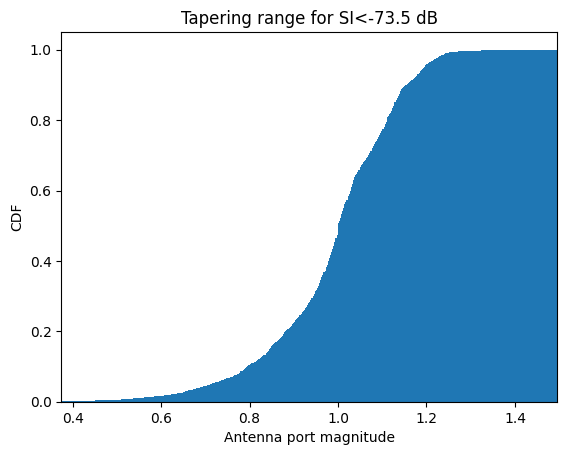

In [14]:
_ = plt.hist(tx_mag, bins=tx_codebooks.size//10, cumulative=True, density=True)
_ = plt.xlabel("Antenna port magnitude")
_ = plt.ylabel("CDF")
_ = plt.xlim(min(tx_mag), max(tx_mag))
_ = plt.title(f"Tapering range for SI<{si_cutoff:.1f} dB")